## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## compute the camera calibration using chessboard images

In [3]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
#         cv2.imshow('img',img)
#         cv2.waitKey(500)

cv2.destroyAllWindows()

## Apply a distortion correction to raw images

In [45]:
import matplotlib.image as mpimg
# Compute the camera calibration with one of the image

# Test undistortion on an image
img = cv2.imread('./camera_cal/calibration8.jpg')

img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)



Text(0.5,1,'Undistorted Image')

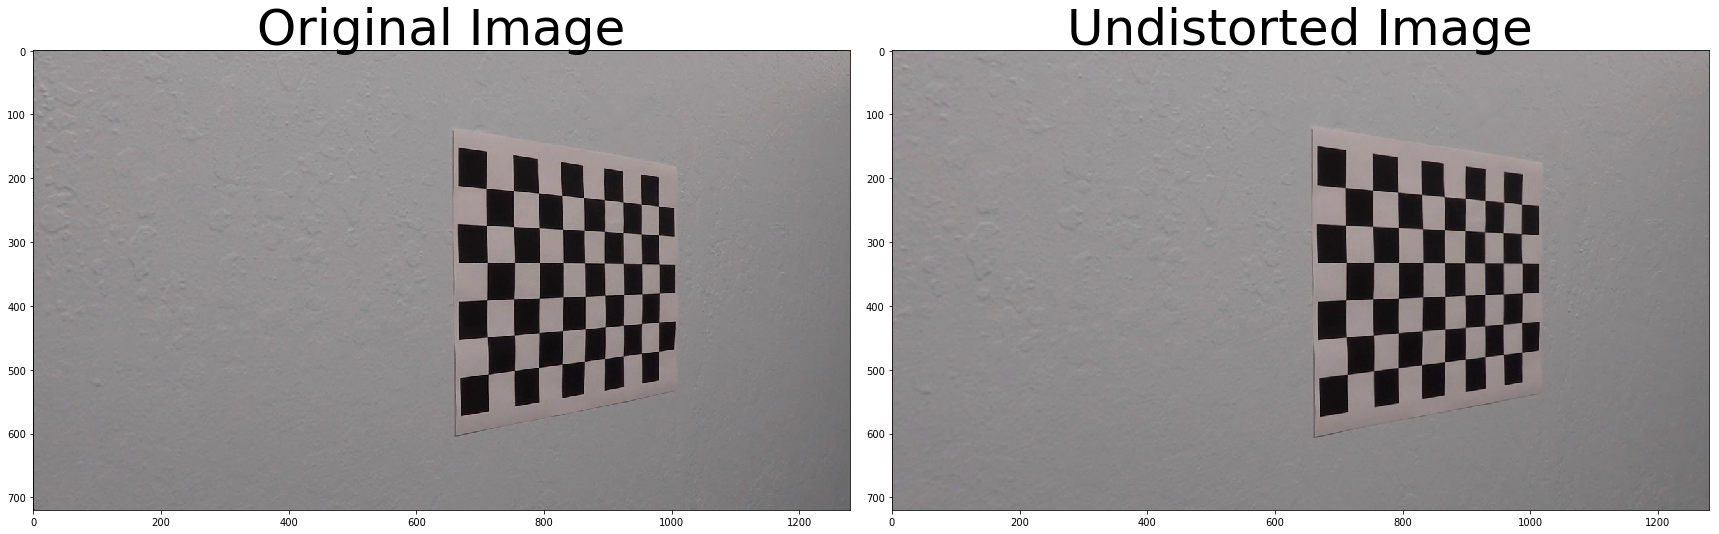

In [47]:
def undistort(image):
    """Undistort the given image based on the maxtrix and 
       distort coeffient above calculated by camera calibration.
    """
    return cv2.undistort(image, mtx, dist, None, mtx)
img = cv2.imread('./camera_cal/calibration8.jpg')
dst = undistort(img)

# Plot the raw image and the undistorted image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
fig.tight_layout()
ax1.imshow(img)
ax2.imshow(dst)
ax1.set_title('Original Image', fontsize=50)
ax2.set_title('Undistorted Image', fontsize=50)

## Use color transforms, gradients, etc., to create a thresholded binary image

In [34]:
# Test the unditort function to a road img
road_img = cv2.imread("./test_images/straight_lines1.jpg.jpg")
road_dst = undistort(road_img)
# Plot the raw image and the undistorted image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
fig.tight_layout()
ax1.imshow(road_img)
ax2.imshow(road_dst)
ax1.set_title('Original Image', fontsize=50)
ax2.set_title('Undistorted Image', fontsize=50)


error: /home/travis/miniconda/conda-bld/conda_1486587069159/work/opencv-3.1.0/modules/imgproc/src/undistort.cpp:191: error: (-215) dst.data != src.data in function undistort


## Use color transforms, gradients, etc., to create a thresholded binary image

This combination works well even in some tricky cases.


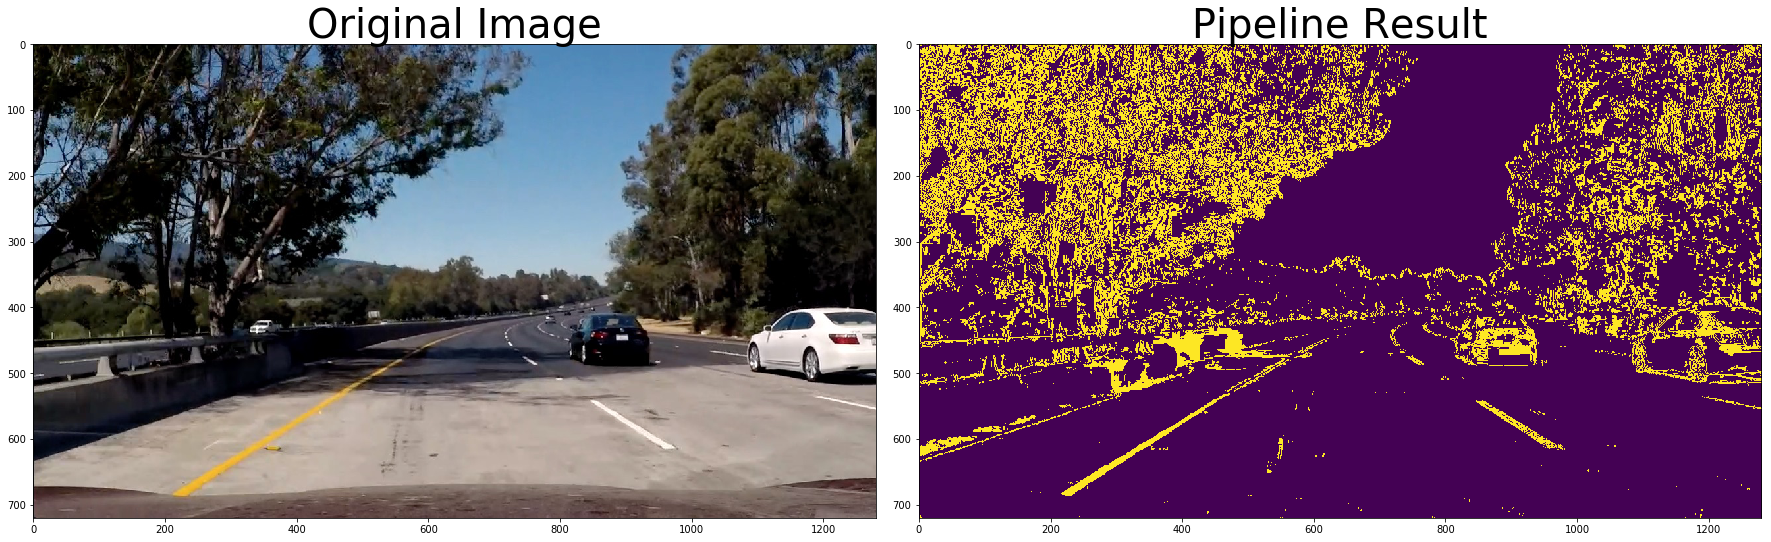

In [63]:
def thresh_to_binary(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    """Combin the S channel (in HSL color channerl) threshold and x-direction gradient threshold"""
    # hls 
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # sober x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    # Threshold S color channel
    schannel_binary = np.zeros_like(s_channel)
    schannel_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Threshold x gradient
    soberx_binary = np.zeros_like(scaled_sobel)
    soberx_binary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    # combine two treshold
    combined_binary = np.zeros_like(soberx_binary)
    combined_binary[(schannel_binary == 1) | (soberx_binary == 1)] = 1
    return combined_binary


# Test this thresh_to_binary() funciton. 
image = mpimg.imread("./test_images/test5.jpg")
result = thresh_to_binary(image)
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result)
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
print("This combination works well even in some tricky cases.")

## Apply a perspective transform to rectify binary image ("birds-eye view").